In [1]:
import sys
from multiprocessing import Pool
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import poisson

# Jack's car rental problem

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $\$10$ by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of $\$2$ per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is n:

$$P(n) = \frac {\lambda^n} {n!} e^{-\lambda}$$
where $\lambda$ is the expected number. Suppose is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

## alternative
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs $\$2,$ as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $\$4$ must be incurred to use a second parking lot (independent of how many cars are kept there).

In [2]:
max_cars = 20
preq1 = poisson(3)
preq2 = poisson(4) #4
pret1 = poisson(3) #3
pret2 = poisson(2)
gamma = 0.9
poisson_iter = 10

In [3]:
class Model():
    def __init__(self, preq1, preq2, pret1, pret2):
        self.preq1 = preq1
        self.preq2 = preq2
        self.pret1 = pret1
        self.pret2 = pret2
        self.preq1_c = {}  # probabilities are saved in a cache; accessing them from a dictionary is much faster
        self.preq2_c = {}
        self.pret1_c = {}
        self.pret2_c = {}
        for requests1 in range(poisson_iter):
            self.preq1_c[requests1] = preq1.pmf(requests1)
        for requests2 in range(poisson_iter):
            self.preq2_c[requests2] = preq2.pmf(requests2)
        for returns1 in range(poisson_iter):
            self.pret1_c[returns1] = pret1.pmf(returns1)
        for returns2 in range(poisson_iter):
            self.pret2_c[returns2] = pret2.pmf(returns2)

In [4]:
model = Model(preq1, preq2, pret1, pret2)

In [5]:
def action_evaluation(loc1, loc2, vs, action, model):
    v=0
    v-=2*np.abs(action)
    cars1 = loc1-action
    cars2 = loc2+action
    for requests1 in range(poisson_iter):
        for requests2 in range(poisson_iter):
            for returns1 in range(poisson_iter):
                for returns2 in range(poisson_iter):
                    rented1 = min(cars1, requests1)
                    rented2 = min(cars2, requests2)
                    reward = (rented1+rented2)*10
                    cars1_left = cars1 - rented1
                    cars2_left = cars2 - rented2
                    prob = model.preq1_c[requests1]*model.preq2_c[requests2]*model.pret1_c[returns1]*model.pret2_c[returns2]
                    final1 = min(cars1_left + returns1, max_cars)
                    final2 = min(cars2_left + returns2, max_cars)
                    v += prob*(reward + gamma*vs[final1,final2])
    return v

## Alternative version

In [6]:
def alt_action_evaluation(loc1, loc2, vs, action, model):
    v=0
    if action > 0:
        v-=2*np.abs(action-1)
    else:
        v-=2*np.abs(action)
    cars1 = loc1-action
    cars2 = loc2+action
    for requests1 in range(poisson_iter):
        for requests2 in range(poisson_iter):
            for returns1 in range(poisson_iter):
                for returns2 in range(poisson_iter):
                    rented1 = min(cars1, requests1)
                    rented2 = min(cars2, requests2)
                    reward = (rented1+rented2)*10
                    cars1_left = cars1 - rented1
                    cars2_left = cars2 - rented2
                    prob = model.preq1_c[requests1]*model.preq2_c[requests2]*model.pret1_c[returns1]*model.pret2_c[returns2]
                    final1 = min(cars1_left + returns1, max_cars)
                    final2 = min(cars2_left + returns2, max_cars)
                    if final1 > 10:
                        reward -= 4
                    if final2 > 10:
                        reward -= 4
                    v += prob*(reward + gamma*vs[final1,final2])
    return v

In [7]:
def policy_evaluation(vs, policy, model, action_evaluation):
    v = np.zeros((max_cars+1,max_cars+1))
    for i in range(max_cars+1):  # cars at location 1
        for j in range(max_cars+1):  # cars at location 2
            v[i,j] = action_evaluaiton(i, j, vs, policy[i,j], model)
    return v

In [8]:
def policy_evaluation_task(vs, policy, model, action_evaluation, i):
    v = np.zeros(max_cars+1)
    for j in range(max_cars+1):  # cars at location 2
        v[j] = action_evaluation(i, j, vs, policy[i, j], model)
    return v

In [9]:
def policy_improvement(vs, model, action_evaluation):
    p = np.zeros((max_cars+1, max_cars+1), dtype='int64')
    for i in range(max_cars+1):  #cars at location 1
        for j in range(max_cars+1):  # cars at location 2
            min_action = max(max(-5, i-max_cars), -min(j, 5))
            max_action = min(min(i, 5), min(max_cars-j, 5))
            possible_actions = range(min_action, max_action+1)
            best = np.argmax([action_evaluation(i, j, vs, action, model) for action in possible_actions])
            p[i,j] = possible_actions[best]
    return p

In [10]:
def policy_improvement_task(vs, model, action_evaluation, i):
    p = np.zeros(max_cars+1, dtype='int64')
    for j in range(max_cars+1): # cars at location 2
        min_action = max(max(-5, i-max_cars), -min(j, 5))
        max_action = min(min(i, 5), min(max_cars-j, 5))
        possible_actions = range(min_action, max_action+1)
        best = np.argmax([action_evaluation(i, j, vs, action, model) for action in possible_actions])
        p[j] = possible_actions[best]
    return p

# I actually chose to use value iteration
## I perform policy improvement at each policy evaluation instead of waiting for convergence: $v(s) \rightarrow v_{\pi}(s)$

In [34]:
policy = np.zeros((21,21), dtype='int64')
vs = np.zeros((21,21), dtype='int64')
with Pool() as p:
    while 1:
        temp_p = policy.copy()
        temp_vs = vs.copy()
        res_evaluation = p.starmap(
            policy_evaluation_task,
            [(vs, policy, model, action_evaluation, i) for i in range(max_cars+1)]
        )
        vs = np.array(res_evaluation)
        res_impr = p.starmap(
            policy_improvement_task,
            [(vs, model, action_evaluation, i) for i in range(max_cars+1)]
        )
        policy = np.array(res_impr, dtype='int64')
        print(f'delta policy: {np.abs(policy-temp_p).mean():.3f} delta value function: {np.abs(vs-temp_vs).mean():.3f}')
        if (policy==temp_p).all():
            break

delta policy: 1.390 delta value function: 59.692
delta policy: 0.222 delta value function: 58.013
delta policy: 0.048 delta value function: 48.865
delta policy: 0.061 delta value function: 42.350
delta policy: 0.048 delta value function: 36.761
delta policy: 0.029 delta value function: 31.951
delta policy: 0.052 delta value function: 27.820
delta policy: 0.002 delta value function: 24.273
delta policy: 0.009 delta value function: 21.223
delta policy: 0.016 delta value function: 18.595
delta policy: 0.016 delta value function: 16.327
delta policy: 0.014 delta value function: 14.364
delta policy: 0.005 delta value function: 12.660
delta policy: 0.002 delta value function: 11.176
delta policy: 0.000 delta value function: 9.881


In [12]:
alt_policy = np.zeros((21,21), dtype='int64')
alt_vs = np.zeros((21,21), dtype='int64')

with Pool() as p:
    while 1:
        temp_p = alt_policy.copy()
        temp_vs = alt_vs.copy()
        res_evaluation = p.starmap(
            policy_evaluation_task,
            [(alt_vs, alt_policy, model, alt_action_evaluation, i) for i in range(max_cars+1)]
        )
        alt_vs = np.array(res_evaluation)
        res_impr = p.starmap(
            policy_improvement_task,
            [(alt_vs, model, alt_action_evaluation, i) for i in range(max_cars+1)]
        )
        alt_policy = np.array(res_impr, dtype='int64')
        print(f'delta policy: {np.abs(alt_policy-temp_p).mean():.3f} delta value function: {np.abs(alt_vs-temp_vs).mean():.3f}')
        if (alt_policy==temp_p).all():
            break

delta policy: 1.671 delta value function: 56.289
delta policy: 0.177 delta value function: 56.767
delta policy: 0.093 delta value function: 48.036
delta policy: 0.052 delta value function: 41.889
delta policy: 0.052 delta value function: 36.590
delta policy: 0.005 delta value function: 31.969
delta policy: 0.014 delta value function: 27.953
delta policy: 0.011 delta value function: 24.468
delta policy: 0.005 delta value function: 21.448
delta policy: 0.016 delta value function: 18.829
delta policy: 0.005 delta value function: 16.558
delta policy: 0.005 delta value function: 14.584
delta policy: 0.005 delta value function: 12.865
delta policy: 0.002 delta value function: 11.365
delta policy: 0.009 delta value function: 10.053
delta policy: 0.007 delta value function: 8.903
delta policy: 0.005 delta value function: 7.892
delta policy: 0.002 delta value function: 7.002
delta policy: 0.002 delta value function: 6.217
delta policy: 0.002 delta value function: 5.523
delta policy: 0.000 delta

In [35]:
directory = 'data/'
os.makedirs(directory, exist_ok = True)
np.savez('data/rental', vs, policy, alt_vs, alt_policy)
data = np.load('data/rental.npz')
vs = data['arr_0']
policy = data['arr_1']
alt_vs = data['arr_2']
alt_policy = data['arr_3']

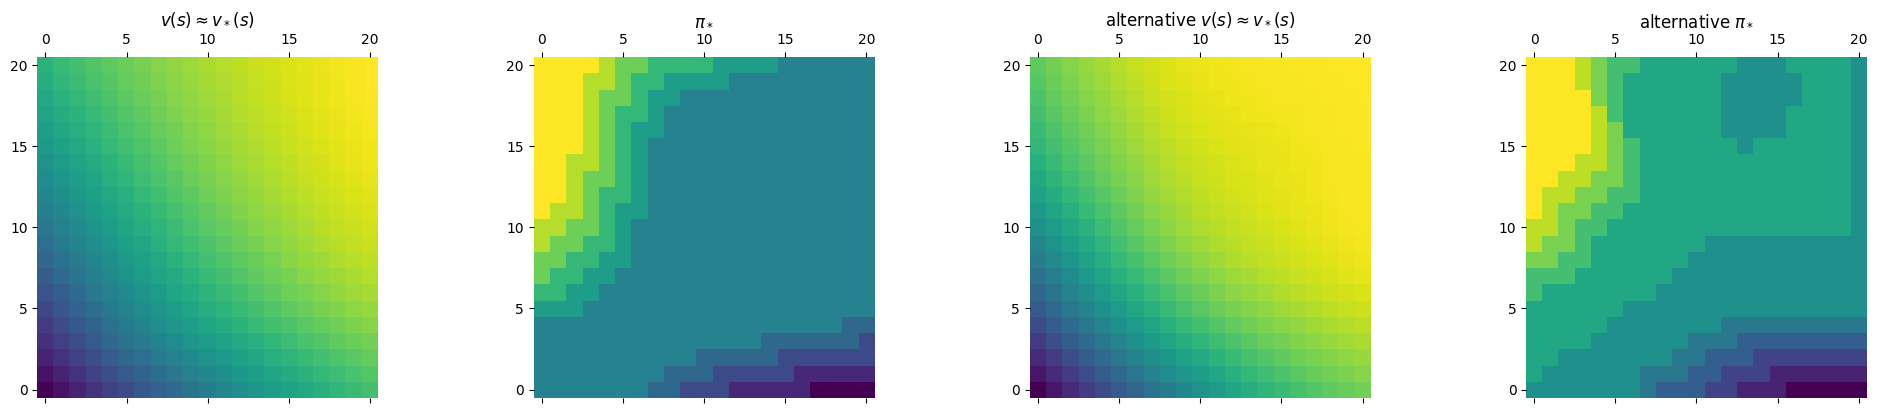

In [36]:
fig, axes = plt.subplots(nrows=1, ncols =4, figsize = (20,4))
fig.tight_layout(h_pad = 6)
#ax1.grid(axis = 'y')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
axes[0].set_title(r'$v(s) \approx v_*(s)$')
axes[1].set_title(r'$\pi_*$')
axes[2].set_title(r'alternative $v(s) \approx v_*(s)$')
axes[3].set_title(r'alternative $\pi_*$')
axes[0].matshow(vs, origin='lower')
axes[1].matshow(policy, origin='lower')
axes[2].matshow(alt_vs, origin='lower')
axes[3].matshow(alt_policy, origin='lower')

In [37]:
def update(loc1, loc2, policy, model):
    action = policy[loc1, loc2]
    reward = -2 * np.abs(action)
    cars1 = loc1 - action
    cars2 = loc2 + action
    rented1 = min(cars1, model.preq1.rvs())
    rented2 = min(cars2, model.preq2.rvs())
    reward += (rented1+rented2)*10
    cars1_left = cars1 - rented1
    cars2_left = cars2 - rented2
    final1 = min(cars1_left + model.pret1.rvs(), max_cars)
    final2 = min(cars2_left + model.pret2.rvs(), max_cars)
    return final1, final2, action, reward

In [38]:
def symulation_task(policy, model, gamma, n_time_steps):
    reward = np.zeros(n_time_steps)
    reward0 = np.zeros(n_time_steps)
    loc1 = np.zeros(n_time_steps, dtype='int64')
    loc2 = np.zeros(n_time_steps, dtype='int64')
    loc1[0] = np.random.randint(0, 21)
    loc2[0] = np.random.randint(0, 21)
    loc10 = loc1.copy()
    loc20 = loc1.copy()
    seed1 = np.random.randint(10000)
    seed2 = np.random.randint(10000)
    seed3 = np.random.randint(10000)
    seed4 = np.random.randint(10000)
    rew = np.zeros(n_time_steps)
    rew0 = np.zeros(n_time_steps)
    pret1.random_state=np.random.default_rng(seed=seed1)
    pret2.random_state=np.random.default_rng(seed=seed2)
    preq1.random_state=np.random.default_rng(seed=seed3)
    preq2.random_state=np.random.default_rng(seed=seed4) 
    for t in range(n_time_steps-1):
        loc1[t+1], loc2[t+1], action, rew[t] = update(loc1[t], loc2[t], policy, model)
    reward += rew
    pret1.random_state=np.random.default_rng(seed=seed1)
    pret2.random_state=np.random.default_rng(seed=seed2)
    preq1.random_state=np.random.default_rng(seed=seed3)
    preq2.random_state=np.random.default_rng(seed=seed4)
    for t in range(n_time_steps-1):
        loc10[t+1], loc20[t+1], action, rew0[t] = update(loc10[t], loc20[t], np.zeros((21,21), dtype='int64'), model)
    reward0 += rew0
    gammas = np.array([gamma**i for i in range(n_time_steps)])
    reward*=gammas
    reward0*=gammas
    return reward, reward0

In [39]:
n_time_steps = 50
n_iter = 500
reward = np.zeros(n_time_steps)
reward0 = np.zeros(n_time_steps)

with Pool() as p:
    res_symulation = p.starmap(
        symulation_task,
        [(policy, model, gamma, n_time_steps) for k in range(n_iter)]
    )

reward = np.array(res_symulation).mean(axis=0)[0,:]
reward0 = np.array(res_symulation).mean(axis=0)[1,:]

<Axes: title={'center': 'Avg reward over 500 iterations'}>

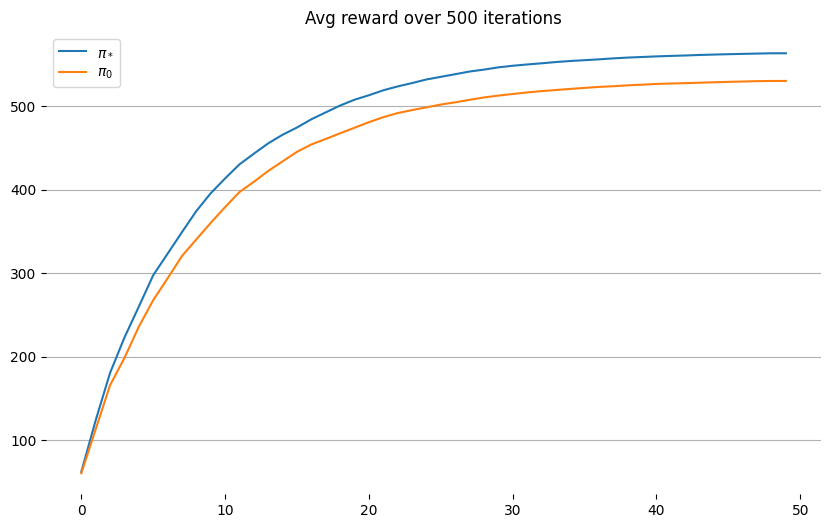

In [40]:
fig, ax = plt.subplots(nrows=1, ncols =1, figsize = (10,6))
ax.grid(axis = 'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(f'Avg reward over {n_iter} iterations')
sns.lineplot(reward.cumsum(), label=r'$\pi_*$')
sns.lineplot(reward0.cumsum(), label=r'$\pi_0$')

<Axes: title={'center': 'reward'}>

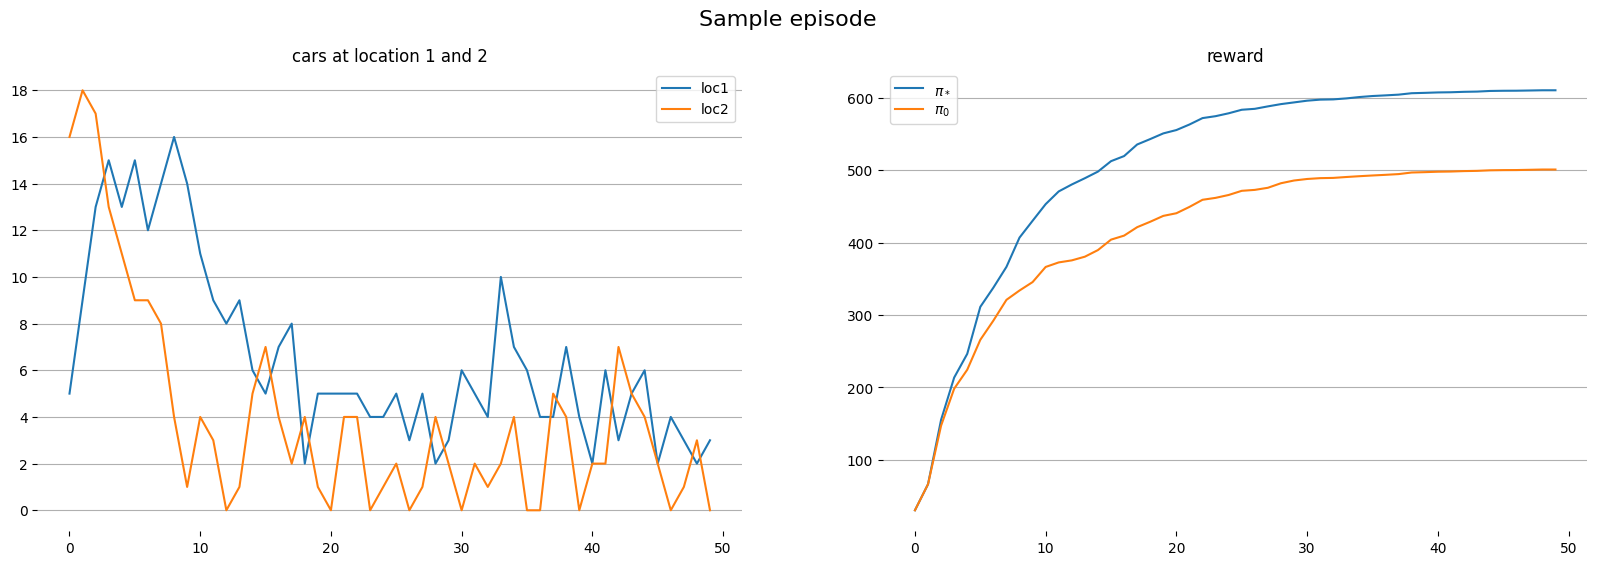

In [52]:
reward = np.zeros(n_time_steps)
reward0 = np.zeros(n_time_steps)
loc1 = np.zeros(n_time_steps, dtype='int64')
loc2 = np.zeros(n_time_steps, dtype='int64')
loc1[0] = np.random.randint(0, 21)
loc2[0] = np.random.randint(0, 21)
loc10 = loc1.copy()
loc20 = loc1.copy()

pret1.random_state=np.random.default_rng(seed=41)
pret2.random_state=np.random.default_rng(seed=42)
preq1.random_state=np.random.default_rng(seed=43)
preq2.random_state=np.random.default_rng(seed=44)

for t in range(n_time_steps-1):
    loc1[t+1], loc2[t+1], action, reward[t] = update(loc1[t], loc2[t], policy, model)

pret1.random_state=np.random.default_rng(seed=41)
pret2.random_state=np.random.default_rng(seed=42)
preq1.random_state=np.random.default_rng(seed=43)
preq2.random_state=np.random.default_rng(seed=44)

for t in range(n_time_steps-1):
    loc10[t+1], loc20[t+1], action, reward0[t] = update(loc10[t], loc20[t], np.zeros((21,21), dtype='int64'), model)

gammas = np.array([gamma**i for i in range(n_time_steps)])
reward*=gammas
reward0*=gammas

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize = (20,6))
ax1.grid(axis = 'y')
ax2.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.set_title('cars at location 1 and 2')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_title('reward')
fig.suptitle('Sample episode', fontsize=16)
sns.lineplot(loc1, label='loc1', ax=ax1)
sns.lineplot(loc2, label='loc2', ax=ax1)
sns.lineplot(reward.cumsum(), label=r'$\pi_*$')
sns.lineplot(reward0.cumsum(), label=r'$\pi_0$')

# Gambler's problem

In [48]:
goal = 100
p = 0.25
s = np.arange(1,100)
vs_g = np.zeros(101)
policy_g = np.ones(99, dtype='int64')
vs_g[100] = 1

In [43]:
def action_eval(s, vs, action):
    reward = p*vs[s+action] + (1-p)*vs[s-action]
    return reward

In [44]:
def policy_eval(vs, policy):
    v = vs.copy()
    for s in range(1,100):
        v[s] = action_eval(s, vs, policy[s-1])
    return v

In [45]:
def policy_impr(vs):
    p = np.zeros(99, dtype='int64')
    for s in range(1,100):
        min_action = 1
        max_action = min(s, 100-s)
        possible_actions = range(min_action, max_action+1)
        best = np.argmax([np.round(action_eval(s, vs, action), 5) for action in possible_actions])
        p[s-1] = possible_actions[best]
    return p

In [49]:
while 1:
    temp_p = policy_g.copy()
    temp_vs = vs_g.copy()
    
    vs_g = policy_eval(vs_g, policy_g)
    policy_g = policy_impr(vs_g)
    
    print(f'delta policy: {np.abs(policy_g-temp_p).mean():.3f} delta value function: {np.abs(vs_g-temp_vs).mean():.3f}', end='')
    print("\r", end='')
    if (policy_g==temp_p).all():
        break

<Axes: title={'center': '$\\pi_*$'}>

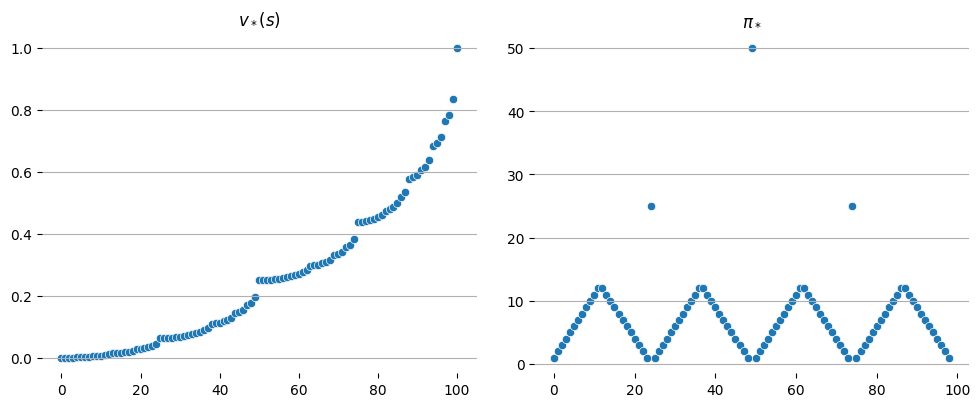

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize = (10,4))
fig.tight_layout(h_pad = 6)
ax1.grid(axis = 'y')
ax2.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.set_title(r'$v_*(s)$')
ax2.set_title(r'$\pi_*$')
sns.scatterplot(vs_g, ax=ax1)
sns.scatterplot(policy_g, ax=ax2)